In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

from sklearn.metrics import (classification_report, matthews_corrcoef,
                            confusion_matrix, ConfusionMatrixDisplay,
                            mean_squared_error, explained_variance_score)

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import KFold, LeaveOneOut, train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_score
from itertools import combinations
from time import time

import seaborn as sns

In [2]:
data = pd.read_csv("parkinsons_updrs.data")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subject#       5875 non-null   int64  
 1   age            5875 non-null   int64  
 2   sex            5875 non-null   int64  
 3   test_time      5875 non-null   float64
 4   motor_UPDRS    5875 non-null   float64
 5   total_UPDRS    5875 non-null   float64
 6   Jitter(%)      5875 non-null   float64
 7   Jitter(Abs)    5875 non-null   float64
 8   Jitter:RAP     5875 non-null   float64
 9   Jitter:PPQ5    5875 non-null   float64
 10  Jitter:DDP     5875 non-null   float64
 11  Shimmer        5875 non-null   float64
 12  Shimmer(dB)    5875 non-null   float64
 13  Shimmer:APQ3   5875 non-null   float64
 14  Shimmer:APQ5   5875 non-null   float64
 15  Shimmer:APQ11  5875 non-null   float64
 16  Shimmer:DDA    5875 non-null   float64
 17  NHR            5875 non-null   float64
 18  HNR     

In [4]:
data.columns

Index(['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS',
       'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP',
       'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE'],
      dtype='object')

In [5]:
#Separate X from y
X = data.drop(columns=["total_UPDRS", "motor_UPDRS"])
y = data["motor_UPDRS"]

In [6]:
#Separate Training set from Independent Validations Set
(X_train, X_IND, 
 y_train, y_IND) = train_test_split(X, y, test_size=361, random_state=361)

In [7]:
#join X and y from the training set
data_train = pd.concat((X_train, y_train), axis=1 )

In [8]:
data_train.head()

,subject#,age,sex,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,...,Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,motor_UPDRS
3376,25,76,0,133.3900,0.00440,0.000042,0.00213,0.00248,0.00638,0.01926,...,0.00901,0.01157,0.01448,0.02703,0.021332,22.334,0.67428,0.59127,0.198900,31.810
1988,14,58,1,161.4300,0.00193,0.000009,0.00090,0.00111,0.00269,0.01222,...,0.00482,0.00598,0.01032,0.01446,0.010531,29.058,0.30348,0.54164,0.127220,18.417
3407,25,76,0,4.4201,0.00371,0.000041,0.00179,0.00215,0.00538,0.02807,...,0.01513,0.01726,0.02422,0.04538,0.017088,19.360,0.60977,0.58733,0.199500,24.268
4985,36,62,1,170.3400,0.00723,0.000046,0.00401,0.00408,0.01204,0.06928,...,0.03409,0.03883,0.05155,0.10226,0.083343,14.029,0.69025,0.56786,0.254170,22.539
2413,17,66,1,167.3000,0.00196,0.000008,0.00108,0.00111,0.00324,0.01205,...,0.00629,0.00682,0.00810,0.01886,0.003008,26.088,0.39965,0.56656,0.077124,22.815


<AxesSubplot:xlabel='test_time'>

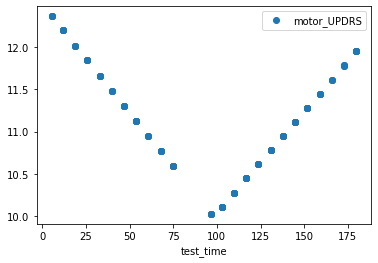

In [9]:
data_train[data_train["subject#"]==20].plot(x="test_time", y = "motor_UPDRS", ls="", marker="o")

In [10]:
data_train.columns

Index(['subject#', 'age', 'sex', 'test_time', 'Jitter(%)', 'Jitter(Abs)',
       'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)',
       'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR',
       'HNR', 'RPDE', 'DFA', 'PPE', 'motor_UPDRS'],
      dtype='object')

In [11]:
data_train.sex.unique()

array([0, 1])

<AxesSubplot:xlabel='sex', ylabel='motor_UPDRS'>

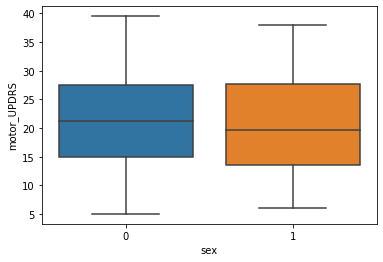

In [12]:
sns.boxplot(data=data_train, x="sex", y="motor_UPDRS")

In [13]:
X_train = X_train.drop(columns=["subject#", "test_time"])

In [14]:
def get_model_statistics_simple(model, X, y):
    kf = KFold(n_splits=16)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=21)

    #fit model
    temp_model = model.fit(X_train, y_train)
    
    #get predictions on train set 
    train_preds = temp_model.predict(X_train)
    #calculate rmse on training set
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    
    #get predictions on test set
    preds = temp_model.predict(X_test)
    #calculate rmse on test set
    test_rmse = np.sqrt(mean_squared_error(y_test, preds))
    
    #get statistics
    pearse = ( np.corrcoef(y_test, preds)[0,1] )
    rve = ( explained_variance_score(y_test, preds) )
    max_err = ( np.abs(y_test - preds).max() )
    
    #return statistics estimations
    return (
        train_rmse,
        test_rmse,
        pearse,
        rve,
        max_err
       )

In [15]:
def get_model_statistics_cv(model, X, y):
    kf = KFold(n_splits=16)
    
    #statistic arrays
    pearse = []
    test_rmse = []
    train_rmse = []
    rve = []
    max_err = []
    
    #Get the train/test folds
    for train_index, test_index in kf.split(X):
        #Create train/test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        #fit model
        temp_model = model.fit(X_train, y_train)
        
        #get predictions on train set
        train_preds = temp_model.predict(X_train)
        
        #get predictions on test set
        preds = temp_model.predict(X_test)
        
        #get statistics
        train_rmse.append(np.sqrt(mean_squared_error(y_train, train_preds)))
        
        pearse.append( np.corrcoef(y_test, preds)[0,1] )
        test_rmse.append( np.sqrt(mean_squared_error(y_test, preds)) )
        rve.append( explained_variance_score(y_test, preds) )
        max_err.append( np.abs(y_test - preds).max() )
    
    #return statistics estimations
    return (
         np.mean(pearse),
         np.mean(test_rmse),
         np.mean(rve),
         np.max(max_err),
        np.mean(train_rmse)
       )

In [16]:
#get_model_statistics(Ridge(), X_train, y_train)

# Ridge Model Evaluation

In [17]:
alphas = np.linspace(0.01, 5, 100)
print(alphas)

[0.01       0.06040404 0.11080808 0.16121212 0.21161616 0.2620202
 0.31242424 0.36282828 0.41323232 0.46363636 0.5140404  0.56444444
 0.61484848 0.66525253 0.71565657 0.76606061 0.81646465 0.86686869
 0.91727273 0.96767677 1.01808081 1.06848485 1.11888889 1.16929293
 1.21969697 1.27010101 1.32050505 1.37090909 1.42131313 1.47171717
 1.52212121 1.57252525 1.62292929 1.67333333 1.72373737 1.77414141
 1.82454545 1.87494949 1.92535354 1.97575758 2.02616162 2.07656566
 2.1269697  2.17737374 2.22777778 2.27818182 2.32858586 2.3789899
 2.42939394 2.47979798 2.53020202 2.58060606 2.6310101  2.68141414
 2.73181818 2.78222222 2.83262626 2.8830303  2.93343434 2.98383838
 3.03424242 3.08464646 3.13505051 3.18545455 3.23585859 3.28626263
 3.33666667 3.38707071 3.43747475 3.48787879 3.53828283 3.58868687
 3.63909091 3.68949495 3.73989899 3.79030303 3.84070707 3.89111111
 3.94151515 3.99191919 4.04232323 4.09272727 4.14313131 4.19353535
 4.24393939 4.29434343 4.34474747 4.39515152 4.44555556 4.495959

In [18]:
results = pd.DataFrame(columns = ["Pearson", "Test RMSE", "RVE", "Max_err", "Train RMSE"])
for alpha in alphas:
    (train_rmse, test_rmse, 
     pearse, rve, max_err) = get_model_statistics_simple(Ridge(alpha=alpha), X_train, y_train)
    
    results.loc[alpha] = {
        "Pearson": pearse,
        "Test RMSE": test_rmse,
        "RVE":rve,
        "Max_err": max_err,
        "Train RMSE": train_rmse
    }

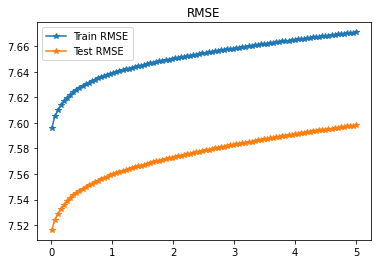

In [19]:
def plot_df(df, column, ax, title="", x_label="", y_label="", legend=""):
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    
    ax.plot(df.index, df[column], "-*", label=legend)
    ax.legend()

f = plt.figure()
ax = plt.axes()
plot_df(results, "Train RMSE", ax, legend="Train RMSE")
plot_df(results, "Test RMSE", ax, legend="Test RMSE", title="RMSE",)


Text(0.5, 1.0, 'Pearson Correlation Coef.')

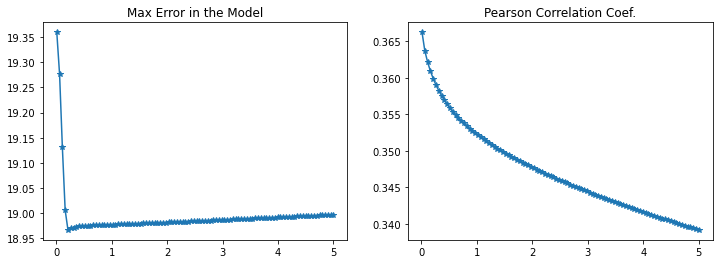

In [20]:
f,ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(results.index, results.Max_err, "-*")
ax[0].set_title("Max Error in the Model")

ax[1].plot(results.index, results.Pearson, '-*')
ax[1].set_title("Pearson Correlation Coef.")

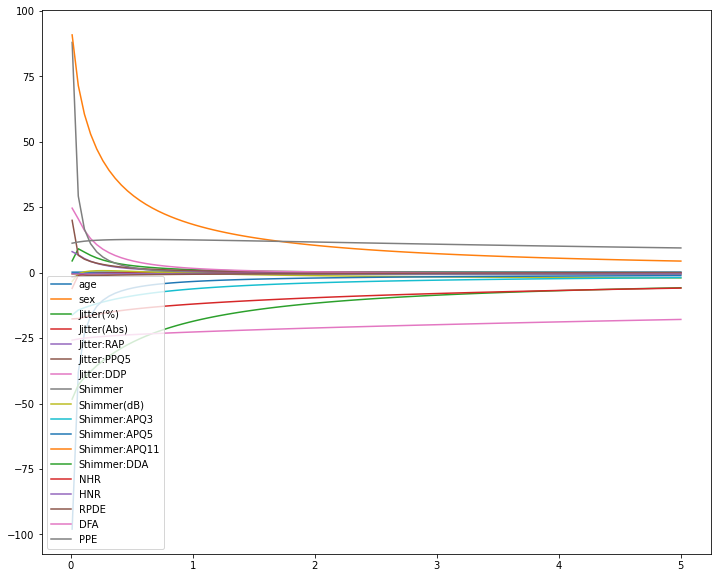

In [21]:
coefs = pd.DataFrame(columns=X_train.columns)
for alpha in alphas:
    model = Ridge(alpha=alpha).fit(X_train, y_train)
    coefs.loc[alpha] = dict(zip(model.feature_names_in_, model.coef_))
coefs.plot(figsize=(12,10));

It seems that the plot alpha/error does not evolves to a "sweet spot".
Instead of a U like shape, the error evolves in a logarithmic manner.



# Lasso Model Evaluation

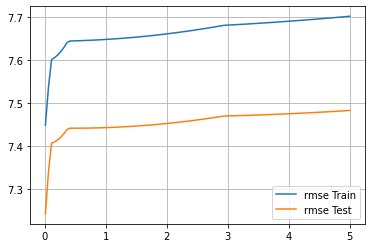

In [22]:
#SIMPLE CROSS VALIDATION
coefs=[]
rmse_train = []
rmse_test = []
alphas = np.linspace(0.01, 5, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=21)

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=100000).fit(X_train, y_train)
    preds_tr=lasso.predict(X_train)
    preds_te=lasso.predict(X_test)
    rmse_train.append(mean_squared_error(y_train, preds_tr, squared=False))
    rmse_test.append(mean_squared_error(y_test, preds_te, squared=False))
    coefs.append(lasso.coef_)
coefs = np.array(coefs)
    
plt.plot(alphas, rmse_train, label="rmse Train")    
plt.plot(alphas, rmse_test, label="rmse Test")    
plt.grid()
plt.legend()
plt.show()


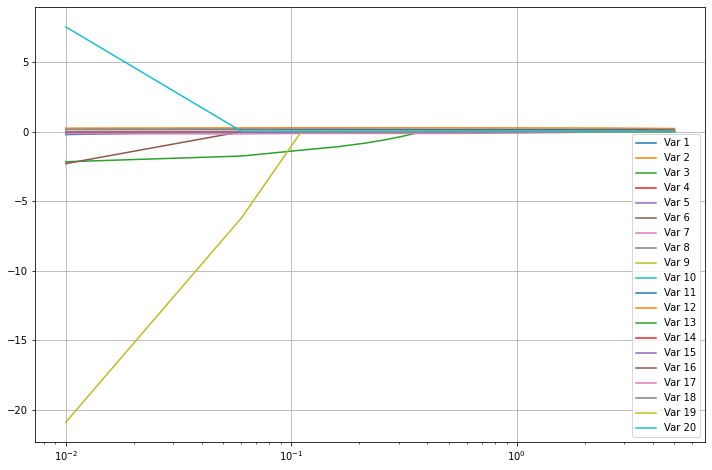

In [23]:
N,M=X_train.shape
plt.figure(figsize=(12,8))
for i in range(M):
    plt.plot(alphas, coefs[:,i], label="Var %d" % (i+1))
plt.xscale("log")
plt.legend()
plt.grid()
plt.show()